# Regression with Fourier Features

Initially observed in: https://arxiv.org/abs/2006.10739

The inclusion of Fourier features allows neural networks to capture high frequency information of the target function. In this short note, we compare a vanilla DNN with another Fourier-feature embedded DNN on the task of learning a (noise-perturbed) high frequency function.

This notebook should be self-contained.

In [4]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import scipy
from collections import OrderedDict

# set random seeds
np.random.seed(10)
torch.manual_seed(10);
torch.set_default_dtype(torch.float64)

import numpy as np    
import matplotlib.pyplot as plt

import time
import pylab as pl
from IPython import display
from IPython.display import clear_output

# import basic DNNs
from PINN.utils.dnn import *

Generate data

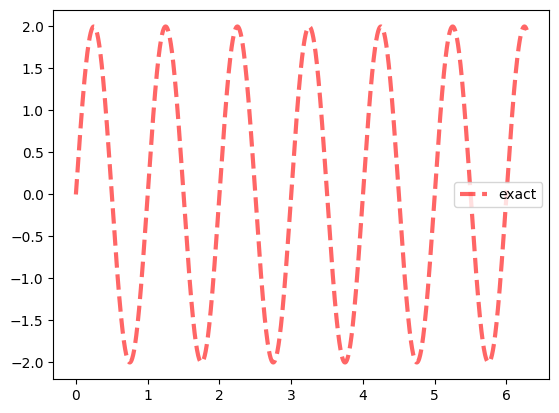

In [5]:
# your code here

# oscillations with decay
#f = lambda x: 100*(np.exp(-2.0*x)*np.sin(10*np.pi*x))+np.cos(5.0*np.pi*x)

# different frequencies
#f = lambda x: np.sin(2*np.pi*x) + np.cos(10.*np.pi*x) + 2.0*np.sin(15.*np.pi*x) + np.sin(100.0*np.pi*x)

# linear function
#f = lambda x: 10.0*(x**2)

# oscillations
f = lambda x: 2.0 * np.sin(2.0*np.pi*x)

# 1/x
#f = lambda x: np.sin(10.0*np.pi/x)
x_start, x_end = 0.0, 2*np.pi
nx = 2048
xgrid = np.linspace(x_start, x_end, nx)
dx = xgrid[1]-xgrid[0]
# visualize function with noise perturbation
f_data = f(xgrid)
noise_level = 0.0
f_data = f_data + noise_level * np.random.randn(f_data.shape[0])
plt.plot(xgrid, f_data, "--", color="red", lw=3.0, label="exact", alpha=0.6);
plt.legend();

In [6]:
# training data
inputs = torch.tensor(xgrid).reshape(-1, 1)
outputs = torch.tensor(f_data).reshape(-1, 1)

# define training function
def train(inputs, outputs, model, optim, scheduler, batch_size, epochs, shuffle=True):
    X, y = inputs, outputs
    nx = X.shape[0]
    num_batches = int(nx/batch_size)
    for i in range(epochs):
        print("============================================================\n")
        print("Epoch = {}\n".format(i+1));
        print("============================================================\n")
        model.train()
        if shuffle:
            tmp = np.random.permutation(nx)
            X, y = X[tmp, :].data.clone(), y[tmp, :].data.clone()
        for idx in range(num_batches):
            print("| => | Batch {} |\n".format(idx+1))
        # closure definition
            def closure():
                optim.zero_grad()
                start_idx = idx*batch_size
                end_idx = (idx+1)*batch_size
                if idx + 1 == num_batches:
                    # if last batch
                    end_idx = -1
                Xb, yb = X[start_idx:end_idx, :].data.clone(), y[start_idx:end_idx, :].data.clone()

                # require gradients
                Xb.requires_grad = True
                # make a prediction on the batch
                y_pred = model.forward(Xb)
                # compute L^2 loss
                loss = torch.mean((y_pred - yb)**2)
                # backpropagate
                loss.backward()
                print("==> Batch {} loss = {}".format(idx, loss.item()))
                return loss
            optim.step(closure=closure)
        if scheduler:
            # step scheduler after epoch if there is one
            scheduler.step()
            print("---------- \n")
            print("++ Learning rate reduced, now at = {}".format(scheduler.get_last_lr()[0]))

Testing neural net performance

In [7]:
# vanilla PINN: initialize optimizer and scheduler
nn_vanilla = DNN(layers=[1, 128, 128, 128, 1])
optim = torch.optim.Adam(
    nn_vanilla.parameters(),
    lr=8e-3
)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9999)
train(inputs, outputs, nn_vanilla, optim, scheduler, 2**10, 500, shuffle=False)


Epoch = 1


| => | Batch 1 |

==> Batch 0 loss = 1.9808361107062167
| => | Batch 2 |

==> Batch 1 loss = 7.657134237836763
---------- 

++ Learning rate reduced, now at = 0.0079992

Epoch = 2


| => | Batch 1 |

==> Batch 0 loss = 3.0828958499129056
| => | Batch 2 |

==> Batch 1 loss = 4.85536430164416
---------- 

++ Learning rate reduced, now at = 0.007998400079999999

Epoch = 3


| => | Batch 1 |

==> Batch 0 loss = 2.2825732955195885
| => | Batch 2 |

==> Batch 1 loss = 2.225056636824656
---------- 

++ Learning rate reduced, now at = 0.007997600239991999

Epoch = 4


| => | Batch 1 |

==> Batch 0 loss = 2.36306096064594
| => | Batch 2 |

==> Batch 1 loss = 2.89311583985132
---------- 

++ Learning rate reduced, now at = 0.007996800479968

Epoch = 5


| => | Batch 1 |

==> Batch 0 loss = 2.1336723078229496
| => | Batch 2 |

==> Batch 1 loss = 2.1896497826234733
---------- 

++ Learning rate reduced, now at = 0.007996000799920003

Epoch = 6


| => | Batch 1 |

==> Batch 0 loss = 1.

==> Batch 1 loss = 2.0692711011302127
---------- 

++ Learning rate reduced, now at = 0.007972047547681863

Epoch = 36


| => | Batch 1 |

==> Batch 0 loss = 1.5426219670438794
| => | Batch 2 |

==> Batch 1 loss = 2.066099473919615
---------- 

++ Learning rate reduced, now at = 0.007971250342927096

Epoch = 37


| => | Batch 1 |

==> Batch 0 loss = 1.532546126478858
| => | Batch 2 |

==> Batch 1 loss = 2.06434586816664
---------- 

++ Learning rate reduced, now at = 0.007970453217892803

Epoch = 38


| => | Batch 1 |

==> Batch 0 loss = 1.5214393591354174
| => | Batch 2 |

==> Batch 1 loss = 2.0642387752172753
---------- 

++ Learning rate reduced, now at = 0.007969656172571013

Epoch = 39


| => | Batch 1 |

==> Batch 0 loss = 1.5073036483745357
| => | Batch 2 |

==> Batch 1 loss = 2.0653854363910256
---------- 

++ Learning rate reduced, now at = 0.007968859206953756

Epoch = 40


| => | Batch 1 |

==> Batch 0 loss = 1.4935882123851254
| => | Batch 2 |

==> Batch 1 loss = 2.06617154

==> Batch 0 loss = 1.2421291418241547
| => | Batch 2 |

==> Batch 1 loss = 2.068257851490725
---------- 

++ Learning rate reduced, now at = 0.007941015562327224

Epoch = 75


| => | Batch 1 |

==> Batch 0 loss = 1.23057617924117
| => | Batch 2 |

==> Batch 1 loss = 2.069125553499817
---------- 

++ Learning rate reduced, now at = 0.007940221460770992

Epoch = 76


| => | Batch 1 |

==> Batch 0 loss = 1.2183854697389047
| => | Batch 2 |

==> Batch 1 loss = 2.069575368853999
---------- 

++ Learning rate reduced, now at = 0.007939427438624915

Epoch = 77


| => | Batch 1 |

==> Batch 0 loss = 1.2057963481662775
| => | Batch 2 |

==> Batch 1 loss = 2.0701472214973813
---------- 

++ Learning rate reduced, now at = 0.007938633495881052

Epoch = 78


| => | Batch 1 |

==> Batch 0 loss = 1.1923445514163329
| => | Batch 2 |

==> Batch 1 loss = 2.0713724795548734
---------- 

++ Learning rate reduced, now at = 0.007937839632531463

Epoch = 79


| => | Batch 1 |

==> Batch 0 loss = 1.177875862

==> Batch 0 loss = 0.9567801161612487
| => | Batch 2 |

==> Batch 1 loss = 2.075766289814062
---------- 

++ Learning rate reduced, now at = 0.007910104372051793

Epoch = 114


| => | Batch 1 |

==> Batch 0 loss = 0.9484537378036888
| => | Batch 2 |

==> Batch 1 loss = 2.0740964545436595
---------- 

++ Learning rate reduced, now at = 0.007909313361614588

Epoch = 115


| => | Batch 1 |

==> Batch 0 loss = 0.9406083077951276
| => | Batch 2 |

==> Batch 1 loss = 2.0729011264961237
---------- 

++ Learning rate reduced, now at = 0.007908522430278427

Epoch = 116


| => | Batch 1 |

==> Batch 0 loss = 0.9336342353445163
| => | Batch 2 |

==> Batch 1 loss = 2.072113757412058
---------- 

++ Learning rate reduced, now at = 0.007907731578035399

Epoch = 117


| => | Batch 1 |

==> Batch 0 loss = 0.9252590831634577
| => | Batch 2 |

==> Batch 1 loss = 2.071234068267447
---------- 

++ Learning rate reduced, now at = 0.007906940804877595

Epoch = 118


| => | Batch 1 |

==> Batch 0 loss = 0.91

==> Batch 0 loss = 0.6689567111692338
| => | Batch 2 |

==> Batch 1 loss = 2.0598837333912017
---------- 

++ Learning rate reduced, now at = 0.007879313506648764

Epoch = 153


| => | Batch 1 |

==> Batch 0 loss = 0.6636006235287792
| => | Batch 2 |

==> Batch 1 loss = 2.059530377625141
---------- 

++ Learning rate reduced, now at = 0.007878525575298098

Epoch = 154


| => | Batch 1 |

==> Batch 0 loss = 0.6575084377976804
| => | Batch 2 |

==> Batch 1 loss = 2.0592875546495586
---------- 

++ Learning rate reduced, now at = 0.007877737722740568

Epoch = 155


| => | Batch 1 |

==> Batch 0 loss = 0.6523432935828334
| => | Batch 2 |

==> Batch 1 loss = 2.059779338205968
---------- 

++ Learning rate reduced, now at = 0.007876949948968294

Epoch = 156


| => | Batch 1 |

==> Batch 0 loss = 0.6465764367920959
| => | Batch 2 |

==> Batch 1 loss = 2.059398048620666
---------- 

++ Learning rate reduced, now at = 0.007876162253973397

Epoch = 157


| => | Batch 1 |

==> Batch 0 loss = 0.63

==> Batch 0 loss = 0.37751592948539764
| => | Batch 2 |

==> Batch 1 loss = 2.088210026313431
---------- 

++ Learning rate reduced, now at = 0.007848642497741636

Epoch = 192


| => | Batch 1 |

==> Batch 0 loss = 0.3727869181203696
| => | Batch 2 |

==> Batch 1 loss = 2.086161401386894
---------- 

++ Learning rate reduced, now at = 0.007847857633491861

Epoch = 193


| => | Batch 1 |

==> Batch 0 loss = 0.37285757426069044
| => | Batch 2 |

==> Batch 1 loss = 2.090406049104178
---------- 

++ Learning rate reduced, now at = 0.007847072847728512

Epoch = 194


| => | Batch 1 |

==> Batch 0 loss = 0.36331160028759546
| => | Batch 2 |

==> Batch 1 loss = 2.089375059684361
---------- 

++ Learning rate reduced, now at = 0.00784628814044374

Epoch = 195


| => | Batch 1 |

==> Batch 0 loss = 0.36620518924549716
| => | Batch 2 |

==> Batch 1 loss = 2.0893935887292616
---------- 

++ Learning rate reduced, now at = 0.007845503511629695

Epoch = 196


| => | Batch 1 |

==> Batch 0 loss = 0.

==> Batch 0 loss = 0.09827391790459504
| => | Batch 2 |

==> Batch 1 loss = 2.079874140923841
---------- 

++ Learning rate reduced, now at = 0.007818090878777124

Epoch = 231


| => | Batch 1 |

==> Batch 0 loss = 0.10062424663362446
| => | Batch 2 |

==> Batch 1 loss = 2.0792522743156554
---------- 

++ Learning rate reduced, now at = 0.007817309069689245

Epoch = 232


| => | Batch 1 |

==> Batch 0 loss = 0.09564944185735534
| => | Batch 2 |

==> Batch 1 loss = 2.0760132404194076
---------- 

++ Learning rate reduced, now at = 0.007816527338782277

Epoch = 233


| => | Batch 1 |

==> Batch 0 loss = 0.10513311156572788
| => | Batch 2 |

==> Batch 1 loss = 2.0769678822505906
---------- 

++ Learning rate reduced, now at = 0.0078157456860484

Epoch = 234


| => | Batch 1 |

==> Batch 0 loss = 0.10058652380112756
| => | Batch 2 |

==> Batch 1 loss = 2.072787495047291
---------- 

++ Learning rate reduced, now at = 0.007814964111479795

Epoch = 235


| => | Batch 1 |

==> Batch 0 loss = 

==> Batch 0 loss = 0.04406951948577129
| => | Batch 2 |

==> Batch 1 loss = 2.001308233013859
---------- 

++ Learning rate reduced, now at = 0.007787658185018033

Epoch = 270


| => | Batch 1 |

==> Batch 0 loss = 0.08536942401681413
| => | Batch 2 |

==> Batch 1 loss = 2.000053350032988
---------- 

++ Learning rate reduced, now at = 0.007786879419199532

Epoch = 271


| => | Batch 1 |

==> Batch 0 loss = 0.1470175179106038
| => | Batch 2 |

==> Batch 1 loss = 1.994059864432892
---------- 

++ Learning rate reduced, now at = 0.007786100731257612

Epoch = 272


| => | Batch 1 |

==> Batch 0 loss = 0.2960037501994056
| => | Batch 2 |

==> Batch 1 loss = 2.056388079734422
---------- 

++ Learning rate reduced, now at = 0.007785322121184487

Epoch = 273


| => | Batch 1 |

==> Batch 0 loss = 0.18329577444151504
| => | Batch 2 |

==> Batch 1 loss = 2.07383459979609
---------- 

++ Learning rate reduced, now at = 0.007784543588972369

Epoch = 274


| => | Batch 1 |

==> Batch 0 loss = 0.07

==> Batch 1 loss = 1.8226797805080481
---------- 

++ Learning rate reduced, now at = 0.00775811976551277

Epoch = 308


| => | Batch 1 |

==> Batch 0 loss = 0.05536068830061688
| => | Batch 2 |

==> Batch 1 loss = 1.8207741493829488
---------- 

++ Learning rate reduced, now at = 0.0077573439535362195

Epoch = 309


| => | Batch 1 |

==> Batch 0 loss = 0.016369853327142327
| => | Batch 2 |

==> Batch 1 loss = 1.8172391556781675
---------- 

++ Learning rate reduced, now at = 0.007756568219140866

Epoch = 310


| => | Batch 1 |

==> Batch 0 loss = 0.03223712816370322
| => | Batch 2 |

==> Batch 1 loss = 1.821898177617681
---------- 

++ Learning rate reduced, now at = 0.007755792562318952

Epoch = 311


| => | Batch 1 |

==> Batch 0 loss = 0.020824811434995594
| => | Batch 2 |

==> Batch 1 loss = 1.815188798900004
---------- 

++ Learning rate reduced, now at = 0.00775501698306272

Epoch = 312


| => | Batch 1 |

==> Batch 0 loss = 0.012800529843310444
| => | Batch 2 |

==> Batch 1 los

==> Batch 1 loss = 1.7749305528103339
---------- 

++ Learning rate reduced, now at = 0.007727920515257047

Epoch = 347


| => | Batch 1 |

==> Batch 0 loss = 0.005237096638759022
| => | Batch 2 |

==> Batch 1 loss = 1.7739191749049377
---------- 

++ Learning rate reduced, now at = 0.007727147723205522

Epoch = 348


| => | Batch 1 |

==> Batch 0 loss = 0.004793775579889863
| => | Batch 2 |

==> Batch 1 loss = 1.7698642474277266
---------- 

++ Learning rate reduced, now at = 0.007726375008433201

Epoch = 349


| => | Batch 1 |

==> Batch 0 loss = 0.00438994663621804
| => | Batch 2 |

==> Batch 1 loss = 1.7637742006277342
---------- 

++ Learning rate reduced, now at = 0.0077256023709323576

Epoch = 350


| => | Batch 1 |

==> Batch 0 loss = 0.003028791430537881
| => | Batch 2 |

==> Batch 1 loss = 1.757331580404668
---------- 

++ Learning rate reduced, now at = 0.007724829810695264

Epoch = 351


| => | Batch 1 |

==> Batch 0 loss = 0.002733652592044012
| => | Batch 2 |

==> Batch 1

==> Batch 1 loss = 1.59345828918384
---------- 

++ Learning rate reduced, now at = 0.007697838818576615

Epoch = 386


| => | Batch 1 |

==> Batch 0 loss = 0.060391169622538356
| => | Batch 2 |

==> Batch 1 loss = 1.60063199610854
---------- 

++ Learning rate reduced, now at = 0.0076970690346947574

Epoch = 387


| => | Batch 1 |

==> Batch 0 loss = 0.018514259255061945
| => | Batch 2 |

==> Batch 1 loss = 1.5274281697090524
---------- 

++ Learning rate reduced, now at = 0.007696299327791288

Epoch = 388


| => | Batch 1 |

==> Batch 0 loss = 0.05875279151184146
| => | Batch 2 |

==> Batch 1 loss = 1.540163619439879
---------- 

++ Learning rate reduced, now at = 0.007695529697858509

Epoch = 389


| => | Batch 1 |

==> Batch 0 loss = 0.020335956750803824
| => | Batch 2 |

==> Batch 1 loss = 1.5435942789059978
---------- 

++ Learning rate reduced, now at = 0.0076947601448887236

Epoch = 390


| => | Batch 1 |

==> Batch 0 loss = 0.02697006453012353
| => | Batch 2 |

==> Batch 1 los

==> Batch 0 loss = 0.0023985126526611935
| => | Batch 2 |

==> Batch 1 loss = 1.5026723643231379
---------- 

++ Learning rate reduced, now at = 0.007668641081990737

Epoch = 424


| => | Batch 1 |

==> Batch 0 loss = 0.002540781793428953
| => | Batch 2 |

==> Batch 1 loss = 1.5038812364206338
---------- 

++ Learning rate reduced, now at = 0.007667874217882537

Epoch = 425


| => | Batch 1 |

==> Batch 0 loss = 0.0022386166642559997
| => | Batch 2 |

==> Batch 1 loss = 1.4901658813529577
---------- 

++ Learning rate reduced, now at = 0.007667107430460749

Epoch = 426


| => | Batch 1 |

==> Batch 0 loss = 0.0018387946396296382
| => | Batch 2 |

==> Batch 1 loss = 1.483542921927722
---------- 

++ Learning rate reduced, now at = 0.007666340719717703

Epoch = 427


| => | Batch 1 |

==> Batch 0 loss = 0.0017890189167531893
| => | Batch 2 |

==> Batch 1 loss = 1.4755782012097256
---------- 

++ Learning rate reduced, now at = 0.0076655740856457315

Epoch = 428


| => | Batch 1 |

==> Ba

==> Batch 1 loss = 1.4259406156212604
---------- 

++ Learning rate reduced, now at = 0.007640318123602252

Epoch = 461


| => | Batch 1 |

==> Batch 0 loss = 0.0010748365327987988
| => | Batch 2 |

==> Batch 1 loss = 1.4219258660204819
---------- 

++ Learning rate reduced, now at = 0.0076395540917898914

Epoch = 462


| => | Batch 1 |

==> Batch 0 loss = 0.00123146462397234
| => | Batch 2 |

==> Batch 1 loss = 1.4181503707200662
---------- 

++ Learning rate reduced, now at = 0.007638790136380713

Epoch = 463


| => | Batch 1 |

==> Batch 0 loss = 0.001470857007703787
| => | Batch 2 |

==> Batch 1 loss = 1.4208819563960664
---------- 

++ Learning rate reduced, now at = 0.007638026257367075

Epoch = 464


| => | Batch 1 |

==> Batch 0 loss = 0.00262236274339104
| => | Batch 2 |

==> Batch 1 loss = 1.4429439073694803
---------- 

++ Learning rate reduced, now at = 0.007637262454741338

Epoch = 465


| => | Batch 1 |

==> Batch 0 loss = 0.0059111597818973845
| => | Batch 2 |

==> Batch

==> Batch 1 loss = 1.613765574562677
---------- 

++ Learning rate reduced, now at = 0.007611338561771613

Epoch = 499


| => | Batch 1 |

==> Batch 0 loss = 0.06512263261065937
| => | Batch 2 |

==> Batch 1 loss = 1.4473981499120159
---------- 

++ Learning rate reduced, now at = 0.007610577427915436

Epoch = 500


| => | Batch 1 |

==> Batch 0 loss = 0.07294843851653697
| => | Batch 2 |

==> Batch 1 loss = 1.4171523713771357
---------- 

++ Learning rate reduced, now at = 0.007609816370172644


In [8]:
# test fourier net
nn_fourier = FourierEmbeddedDNN(
    layers=[30, 128, 128, 128, 1],
    m=15, 
    freq_stds=[1.,2.,5.,10.,20.,50.,60.,70.,80.,90.,100,]
)
optim = torch.optim.Adam(
    nn_fourier.parameters(),
    lr=8e-3
)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9999)
train(inputs, outputs, nn_fourier, optim, scheduler, 2**10, 500, shuffle=False)


Epoch = 1


| => | Batch 1 |

==> Batch 0 loss = 2.01496536867803
| => | Batch 2 |

==> Batch 1 loss = 2.007672459676306
---------- 

++ Learning rate reduced, now at = 0.0079992

Epoch = 2


| => | Batch 1 |

==> Batch 0 loss = 1.5651822142840166
| => | Batch 2 |

==> Batch 1 loss = 1.5189184823799302
---------- 

++ Learning rate reduced, now at = 0.007998400079999999

Epoch = 3


| => | Batch 1 |

==> Batch 0 loss = 1.3839973495505409
| => | Batch 2 |

==> Batch 1 loss = 1.412931068035669
---------- 

++ Learning rate reduced, now at = 0.007997600239991999

Epoch = 4


| => | Batch 1 |

==> Batch 0 loss = 1.191544132139962
| => | Batch 2 |

==> Batch 1 loss = 1.3843625235935724
---------- 

++ Learning rate reduced, now at = 0.007996800479968

Epoch = 5


| => | Batch 1 |

==> Batch 0 loss = 1.0318577654147196
| => | Batch 2 |

==> Batch 1 loss = 1.2742980794371044
---------- 

++ Learning rate reduced, now at = 0.007996000799920003

Epoch = 6


| => | Batch 1 |

==> Batch 0 loss =

==> Batch 1 loss = 0.04543788795660308
---------- 

++ Learning rate reduced, now at = 0.007978428056614032

Epoch = 28


| => | Batch 1 |

==> Batch 0 loss = 0.0437016119983901
| => | Batch 2 |

==> Batch 1 loss = 0.04608831093014725
---------- 

++ Learning rate reduced, now at = 0.007977630213808371

Epoch = 29


| => | Batch 1 |

==> Batch 0 loss = 0.03938798451957868
| => | Batch 2 |

==> Batch 1 loss = 0.039383119687916406
---------- 

++ Learning rate reduced, now at = 0.00797683245078699

Epoch = 30


| => | Batch 1 |

==> Batch 0 loss = 0.03258096349994703
| => | Batch 2 |

==> Batch 1 loss = 0.03370259816407554
---------- 

++ Learning rate reduced, now at = 0.007976034767541912

Epoch = 31


| => | Batch 1 |

==> Batch 0 loss = 0.035146800547942364
| => | Batch 2 |

==> Batch 1 loss = 0.02715903667675944
---------- 

++ Learning rate reduced, now at = 0.007975237164065159

Epoch = 32


| => | Batch 1 |

==> Batch 0 loss = 0.030081157879279632
| => | Batch 2 |

==> Batch 1 lo

==> Batch 0 loss = 0.0067261636780814585
| => | Batch 2 |

==> Batch 1 loss = 0.007050317582235673
---------- 

++ Learning rate reduced, now at = 0.007957710052826033

Epoch = 54


| => | Batch 1 |

==> Batch 0 loss = 0.006400233761504354
| => | Batch 2 |

==> Batch 1 loss = 0.0067682785608918754
---------- 

++ Learning rate reduced, now at = 0.007956914281820751

Epoch = 55


| => | Batch 1 |

==> Batch 0 loss = 0.006137380034092419
| => | Batch 2 |

==> Batch 1 loss = 0.0065528412498065585
---------- 

++ Learning rate reduced, now at = 0.00795611859039257

Epoch = 56


| => | Batch 1 |

==> Batch 0 loss = 0.005901249522276613
| => | Batch 2 |

==> Batch 1 loss = 0.00625194800017263
---------- 

++ Learning rate reduced, now at = 0.007955322978533531

Epoch = 57


| => | Batch 1 |

==> Batch 0 loss = 0.005690048998936537
| => | Batch 2 |

==> Batch 1 loss = 0.006022692095806519
---------- 

++ Learning rate reduced, now at = 0.007954527446235678

Epoch = 58


| => | Batch 1 |

==> 

==> Batch 0 loss = 0.0027722152910914406
| => | Batch 2 |

==> Batch 1 loss = 0.002951513394928786
---------- 

++ Learning rate reduced, now at = 0.007936252143983354

Epoch = 81


| => | Batch 1 |

==> Batch 0 loss = 0.0026976321809370077
| => | Batch 2 |

==> Batch 1 loss = 0.0028739688489515794
---------- 

++ Learning rate reduced, now at = 0.007935458518768956

Epoch = 82


| => | Batch 1 |

==> Batch 0 loss = 0.0026287636295425952
| => | Batch 2 |

==> Batch 1 loss = 0.002797549164814291
---------- 

++ Learning rate reduced, now at = 0.00793466497291708

Epoch = 83


| => | Batch 1 |

==> Batch 0 loss = 0.0025619704431686643
| => | Batch 2 |

==> Batch 1 loss = 0.0027254931811025824
---------- 

++ Learning rate reduced, now at = 0.007933871506419788

Epoch = 84


| => | Batch 1 |

==> Batch 0 loss = 0.0024949014745321504
| => | Batch 2 |

==> Batch 1 loss = 0.0026574508092456033
---------- 

++ Learning rate reduced, now at = 0.007933078119269146

Epoch = 85


| => | Batch 1 |

==> Batch 0 loss = 0.0014600122931737916
| => | Batch 2 |

==> Batch 1 loss = 0.0015572525604456002
---------- 

++ Learning rate reduced, now at = 0.007914852096240009

Epoch = 108


| => | Batch 1 |

==> Batch 0 loss = 0.0014278419495964774
| => | Batch 2 |

==> Batch 1 loss = 0.001525321563498616
---------- 

++ Learning rate reduced, now at = 0.007914060611030385

Epoch = 109


| => | Batch 1 |

==> Batch 0 loss = 0.0014006721699195747
| => | Batch 2 |

==> Batch 1 loss = 0.001493614118851174
---------- 

++ Learning rate reduced, now at = 0.007913269204969282

Epoch = 110


| => | Batch 1 |

==> Batch 0 loss = 0.001369532660619181
| => | Batch 2 |

==> Batch 1 loss = 0.0014638337931524444
---------- 

++ Learning rate reduced, now at = 0.007912477878048784

Epoch = 111


| => | Batch 1 |

==> Batch 0 loss = 0.0013459223539722472
| => | Batch 2 |

==> Batch 1 loss = 0.0014344314178590081
---------- 

++ Learning rate reduced, now at = 0.00791168663026098

Epoch = 112


| => | Batch

==> Batch 0 loss = 0.04040591451127436
| => | Batch 2 |

==> Batch 1 loss = 0.004934536509836297
---------- 

++ Learning rate reduced, now at = 0.007893509753573962

Epoch = 135


| => | Batch 1 |

==> Batch 0 loss = 0.04016883972955303
| => | Batch 2 |

==> Batch 1 loss = 0.004979519761177318
---------- 

++ Learning rate reduced, now at = 0.007892720402598604

Epoch = 136


| => | Batch 1 |

==> Batch 0 loss = 0.016864389635712403
| => | Batch 2 |

==> Batch 1 loss = 0.011705638617689038
---------- 

++ Learning rate reduced, now at = 0.007891931130558345

Epoch = 137


| => | Batch 1 |

==> Batch 0 loss = 0.004376825663288
| => | Batch 2 |

==> Batch 1 loss = 0.0113695040586397
---------- 

++ Learning rate reduced, now at = 0.007891141937445289

Epoch = 138


| => | Batch 1 |

==> Batch 0 loss = 0.007566082385089904
| => | Batch 2 |

==> Batch 1 loss = 0.004325881011329607
---------- 

++ Learning rate reduced, now at = 0.007890352823251545

Epoch = 139


| => | Batch 1 |

==> Bat

==> Batch 0 loss = 0.0008480287601240128
| => | Batch 2 |

==> Batch 1 loss = 0.0009735240907032552
---------- 

++ Learning rate reduced, now at = 0.007872224960383877

Epoch = 162


| => | Batch 1 |

==> Batch 0 loss = 0.0008645718934757901
| => | Batch 2 |

==> Batch 1 loss = 0.0008921136685761281
---------- 

++ Learning rate reduced, now at = 0.00787143773788784

Epoch = 163


| => | Batch 1 |

==> Batch 0 loss = 0.0008617905215879006
| => | Batch 2 |

==> Batch 1 loss = 0.0008839791275849708
---------- 

++ Learning rate reduced, now at = 0.007870650594114051

Epoch = 164


| => | Batch 1 |

==> Batch 0 loss = 0.0008156992009752229
| => | Batch 2 |

==> Batch 1 loss = 0.0008942393229282811
---------- 

++ Learning rate reduced, now at = 0.00786986352905464

Epoch = 165


| => | Batch 1 |

==> Batch 0 loss = 0.0007762374270074027
| => | Batch 2 |

==> Batch 1 loss = 0.0008610752490087758
---------- 

++ Learning rate reduced, now at = 0.007869076542701735

Epoch = 166


| => | Bat

==> Batch 0 loss = 0.0005411523620351408
| => | Batch 2 |

==> Batch 1 loss = 0.0005725479423626069
---------- 

++ Learning rate reduced, now at = 0.007850997561488006

Epoch = 189


| => | Batch 1 |

==> Batch 0 loss = 0.0005342505913320814
| => | Batch 2 |

==> Batch 1 loss = 0.0005649338260421666
---------- 

++ Learning rate reduced, now at = 0.007850212461731856

Epoch = 190


| => | Batch 1 |

==> Batch 0 loss = 0.0005267358197093908
| => | Batch 2 |

==> Batch 1 loss = 0.000557050007184619
---------- 

++ Learning rate reduced, now at = 0.007849427440485683

Epoch = 191


| => | Batch 1 |

==> Batch 0 loss = 0.0005200371726088494
| => | Batch 2 |

==> Batch 1 loss = 0.0005494393604509986
---------- 

++ Learning rate reduced, now at = 0.007848642497741636

Epoch = 192


| => | Batch 1 |

==> Batch 0 loss = 0.0005133323368750935
| => | Batch 2 |

==> Batch 1 loss = 0.0005421118542174952
---------- 

++ Learning rate reduced, now at = 0.007847857633491861

Epoch = 193


| => | Ba

==> Batch 0 loss = 0.000398774884697396
| => | Batch 2 |

==> Batch 1 loss = 0.00041683711241167684
---------- 

++ Learning rate reduced, now at = 0.007829827402123036

Epoch = 216


| => | Batch 1 |

==> Batch 0 loss = 0.00039159616489301187
| => | Batch 2 |

==> Batch 1 loss = 0.000419976762355281
---------- 

++ Learning rate reduced, now at = 0.007829044419382824

Epoch = 217


| => | Batch 1 |

==> Batch 0 loss = 0.000390689278562626
| => | Batch 2 |

==> Batch 1 loss = 0.0004164610373623312
---------- 

++ Learning rate reduced, now at = 0.007828261514940886

Epoch = 218


| => | Batch 1 |

==> Batch 0 loss = 0.00040599922570941436
| => | Batch 2 |

==> Batch 1 loss = 0.00040137442039038117
---------- 

++ Learning rate reduced, now at = 0.007827478688789392

Epoch = 219


| => | Batch 1 |

==> Batch 0 loss = 0.00043413663167597726
| => | Batch 2 |

==> Batch 1 loss = 0.0004011153431641911
---------- 

++ Learning rate reduced, now at = 0.007826695940920513

Epoch = 220


| => |

==> Batch 0 loss = 0.0017177035887585414
| => | Batch 2 |

==> Batch 1 loss = 0.001868236376787468
---------- 

++ Learning rate reduced, now at = 0.007808714327942979

Epoch = 243


| => | Batch 1 |

==> Batch 0 loss = 0.0024001191930923243
| => | Batch 2 |

==> Batch 1 loss = 0.0013216720957506872
---------- 

++ Learning rate reduced, now at = 0.007807933456510184

Epoch = 244


| => | Batch 1 |

==> Batch 0 loss = 0.002905374265673413
| => | Batch 2 |

==> Batch 1 loss = 0.0013714482510745283
---------- 

++ Learning rate reduced, now at = 0.007807152663164533

Epoch = 245


| => | Batch 1 |

==> Batch 0 loss = 0.0019515009677788294
| => | Batch 2 |

==> Batch 1 loss = 0.0014156158494640697
---------- 

++ Learning rate reduced, now at = 0.007806371947898217

Epoch = 246


| => | Batch 1 |

==> Batch 0 loss = 0.0013262992201683139
| => | Batch 2 |

==> Batch 1 loss = 0.0007281225531791712
---------- 

++ Learning rate reduced, now at = 0.007805591310703427

Epoch = 247


| => | Bat

==> Batch 1 loss = 0.000310650824553229
---------- 

++ Learning rate reduced, now at = 0.0077884370287209055

Epoch = 269


| => | Batch 1 |

==> Batch 0 loss = 0.0003151694324745255
| => | Batch 2 |

==> Batch 1 loss = 0.00030504608843313685
---------- 

++ Learning rate reduced, now at = 0.007787658185018033

Epoch = 270


| => | Batch 1 |

==> Batch 0 loss = 0.0003077774372050319
| => | Batch 2 |

==> Batch 1 loss = 0.0003001228049914896
---------- 

++ Learning rate reduced, now at = 0.007786879419199532

Epoch = 271


| => | Batch 1 |

==> Batch 0 loss = 0.00030359130781156283
| => | Batch 2 |

==> Batch 1 loss = 0.00029309796232439587
---------- 

++ Learning rate reduced, now at = 0.007786100731257612

Epoch = 272


| => | Batch 1 |

==> Batch 0 loss = 0.0003003194204370439
| => | Batch 2 |

==> Batch 1 loss = 0.00028779867164020496
---------- 

++ Learning rate reduced, now at = 0.007785322121184487

Epoch = 273


| => | Batch 1 |

==> Batch 0 loss = 0.00029758766892140273
| =

==> Batch 1 loss = 0.00022502820424321652
---------- 

++ Learning rate reduced, now at = 0.007768212384628281

Epoch = 295


| => | Batch 1 |

==> Batch 0 loss = 0.0002345218772375371
| => | Batch 2 |

==> Batch 1 loss = 0.00022290101384818116
---------- 

++ Learning rate reduced, now at = 0.007767435563389818

Epoch = 296


| => | Batch 1 |

==> Batch 0 loss = 0.00023231774357836572
| => | Batch 2 |

==> Batch 1 loss = 0.00022083076803725043
---------- 

++ Learning rate reduced, now at = 0.007766658819833479

Epoch = 297


| => | Batch 1 |

==> Batch 0 loss = 0.00023025414545533514
| => | Batch 2 |

==> Batch 1 loss = 0.00021874191731614557
---------- 

++ Learning rate reduced, now at = 0.007765882153951496

Epoch = 298


| => | Batch 1 |

==> Batch 0 loss = 0.00022819442118549927
| => | Batch 2 |

==> Batch 1 loss = 0.00021675259446164163
---------- 

++ Learning rate reduced, now at = 0.007765105565736101

Epoch = 299


| => | Batch 1 |

==> Batch 0 loss = 0.00022617750787967976

==> Batch 0 loss = 0.00018871601423205628
| => | Batch 2 |

==> Batch 1 loss = 0.0001778128655428316
---------- 

++ Learning rate reduced, now at = 0.007747265454906863

Epoch = 322


| => | Batch 1 |

==> Batch 0 loss = 0.00018727320998919648
| => | Batch 2 |

==> Batch 1 loss = 0.00017638582398114613
---------- 

++ Learning rate reduced, now at = 0.007746490728361372

Epoch = 323


| => | Batch 1 |

==> Batch 0 loss = 0.00018584528772862667
| => | Batch 2 |

==> Batch 1 loss = 0.00017498227156070018
---------- 

++ Learning rate reduced, now at = 0.007745716079288536

Epoch = 324


| => | Batch 1 |

==> Batch 0 loss = 0.00018443784540658244
| => | Batch 2 |

==> Batch 1 loss = 0.00017359144352047944
---------- 

++ Learning rate reduced, now at = 0.007744941507680608

Epoch = 325


| => | Batch 1 |

==> Batch 0 loss = 0.00018304578467386975
| => | Batch 2 |

==> Batch 1 loss = 0.00017222319071928704
---------- 

++ Learning rate reduced, now at = 0.007744167013529839

Epoch = 326



==> Batch 1 loss = 0.00014596045637844555
---------- 

++ Learning rate reduced, now at = 0.007727147723205522

Epoch = 348


| => | Batch 1 |

==> Batch 0 loss = 0.0001551959687460938
| => | Batch 2 |

==> Batch 1 loss = 0.0001449078579287468
---------- 

++ Learning rate reduced, now at = 0.007726375008433201

Epoch = 349


| => | Batch 1 |

==> Batch 0 loss = 0.00015417749598963906
| => | Batch 2 |

==> Batch 1 loss = 0.00014391085680540996
---------- 

++ Learning rate reduced, now at = 0.0077256023709323576

Epoch = 350


| => | Batch 1 |

==> Batch 0 loss = 0.00015315155790549535
| => | Batch 2 |

==> Batch 1 loss = 0.00014288493188121905
---------- 

++ Learning rate reduced, now at = 0.007724829810695264

Epoch = 351


| => | Batch 1 |

==> Batch 0 loss = 0.0001522078711181614
| => | Batch 2 |

==> Batch 1 loss = 0.0001419472858454323
---------- 

++ Learning rate reduced, now at = 0.007724057327714195

Epoch = 352


| => | Batch 1 |

==> Batch 0 loss = 0.0001512741252013259
| 

==> Batch 0 loss = 0.018159860048171602
| => | Batch 2 |

==> Batch 1 loss = 0.006786541422166397
---------- 

++ Learning rate reduced, now at = 0.007707082232276248

Epoch = 374


| => | Batch 1 |

==> Batch 0 loss = 0.010641672829000779
| => | Batch 2 |

==> Batch 1 loss = 0.009951592965524444
---------- 

++ Learning rate reduced, now at = 0.007706311524053021

Epoch = 375


| => | Batch 1 |

==> Batch 0 loss = 0.004145579543351151
| => | Batch 2 |

==> Batch 1 loss = 0.013886241499905333
---------- 

++ Learning rate reduced, now at = 0.007705540892900616

Epoch = 376


| => | Batch 1 |

==> Batch 0 loss = 0.006059054490734554
| => | Batch 2 |

==> Batch 1 loss = 0.009773968357323366
---------- 

++ Learning rate reduced, now at = 0.007704770338811326

Epoch = 377


| => | Batch 1 |

==> Batch 0 loss = 0.009779395297418728
| => | Batch 2 |

==> Batch 1 loss = 0.002208240363173247
---------- 

++ Learning rate reduced, now at = 0.007703999861777445

Epoch = 378


| => | Batch 1 |



==> Batch 0 loss = 0.00024156623465337602
| => | Batch 2 |

==> Batch 1 loss = 0.00022156509973176024
---------- 

++ Learning rate reduced, now at = 0.0076863001395780445

Epoch = 401


| => | Batch 1 |

==> Batch 0 loss = 0.00024310757501384294
| => | Batch 2 |

==> Batch 1 loss = 0.00017828723052789664
---------- 

++ Learning rate reduced, now at = 0.007685531509564087

Epoch = 402


| => | Batch 1 |

==> Batch 0 loss = 0.00023391090960540365
| => | Batch 2 |

==> Batch 1 loss = 0.00017254643367464623
---------- 

++ Learning rate reduced, now at = 0.0076847629564131305

Epoch = 403


| => | Batch 1 |

==> Batch 0 loss = 0.0001976723169101465
| => | Batch 2 |

==> Batch 1 loss = 0.00018411231516383763
---------- 

++ Learning rate reduced, now at = 0.00768399448011749

Epoch = 404


| => | Batch 1 |

==> Batch 0 loss = 0.00017978319618397657
| => | Batch 2 |

==> Batch 1 loss = 0.00016539395796802254
---------- 

++ Learning rate reduced, now at = 0.007683226080669478

Epoch = 405


==> Batch 1 loss = 0.00011639301653197625
---------- 

++ Learning rate reduced, now at = 0.007666340719717703

Epoch = 427


| => | Batch 1 |

==> Batch 0 loss = 0.0001266975996437572
| => | Batch 2 |

==> Batch 1 loss = 0.00011521433744006608
---------- 

++ Learning rate reduced, now at = 0.0076655740856457315

Epoch = 428


| => | Batch 1 |

==> Batch 0 loss = 0.00012545186556222807
| => | Batch 2 |

==> Batch 1 loss = 0.00011416787675330657
---------- 

++ Learning rate reduced, now at = 0.007664807528237167

Epoch = 429


| => | Batch 1 |

==> Batch 0 loss = 0.00012416079390565558
| => | Batch 2 |

==> Batch 1 loss = 0.0001131451479139214
---------- 

++ Learning rate reduced, now at = 0.007664041047484343

Epoch = 430


| => | Batch 1 |

==> Batch 0 loss = 0.00012299026723596623
| => | Batch 2 |

==> Batch 1 loss = 0.00011208403239614567
---------- 

++ Learning rate reduced, now at = 0.007663274643379595

Epoch = 431


| => | Batch 1 |

==> Batch 0 loss = 0.00012189392978712477

==> Batch 0 loss = 0.00010200607654594712
| => | Batch 2 |

==> Batch 1 loss = 9.355492451506675e-05
---------- 

++ Learning rate reduced, now at = 0.007645668486219796

Epoch = 454


| => | Batch 1 |

==> Batch 0 loss = 0.00010128046003974372
| => | Batch 2 |

==> Batch 1 loss = 9.289514363959627e-05
---------- 

++ Learning rate reduced, now at = 0.007644903919371174

Epoch = 455


| => | Batch 1 |

==> Batch 0 loss = 0.00010055581549124177
| => | Batch 2 |

==> Batch 1 loss = 9.226406043906922e-05
---------- 

++ Learning rate reduced, now at = 0.007644139428979236

Epoch = 456


| => | Batch 1 |

==> Batch 0 loss = 9.985247383703289e-05
| => | Batch 2 |

==> Batch 1 loss = 9.163647863590173e-05
---------- 

++ Learning rate reduced, now at = 0.0076433750150363385

Epoch = 457


| => | Batch 1 |

==> Batch 0 loss = 9.91364489809829e-05
| => | Batch 2 |

==> Batch 1 loss = 9.102447651578678e-05
---------- 

++ Learning rate reduced, now at = 0.007642610677534835

Epoch = 458


| => 

==> Batch 0 loss = 8.528719371120387e-05
| => | Batch 2 |

==> Batch 1 loss = 7.88631696293439e-05
---------- 

++ Learning rate reduced, now at = 0.007625051995253224

Epoch = 481


| => | Batch 1 |

==> Batch 0 loss = 8.477041369500595e-05
| => | Batch 2 |

==> Batch 1 loss = 7.841171284876892e-05
---------- 

++ Learning rate reduced, now at = 0.007624289490053699

Epoch = 482


| => | Batch 1 |

==> Batch 0 loss = 8.424725708682115e-05
| => | Batch 2 |

==> Batch 1 loss = 7.795898161541259e-05
---------- 

++ Learning rate reduced, now at = 0.007623527061104694

Epoch = 483


| => | Batch 1 |

==> Batch 0 loss = 8.373976761873552e-05
| => | Batch 2 |

==> Batch 1 loss = 7.7518518391546e-05
---------- 

++ Learning rate reduced, now at = 0.0076227647083985835

Epoch = 484


| => | Batch 1 |

==> Batch 0 loss = 8.323698020255435e-05
| => | Batch 2 |

==> Batch 1 loss = 7.706769908427988e-05
---------- 

++ Learning rate reduced, now at = 0.007622002431927744

Epoch = 485


| => | Bat

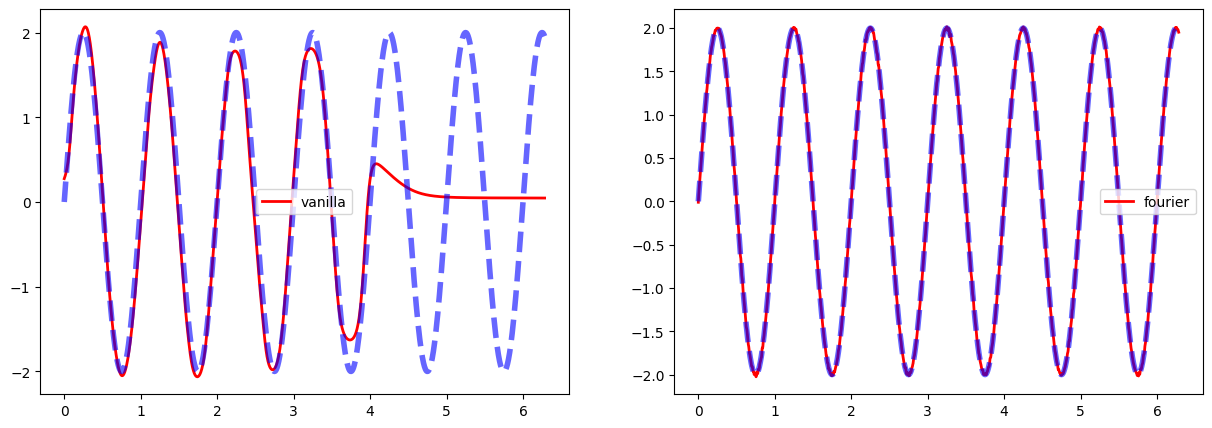

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5));
ax[0].plot(xgrid, nn_vanilla(inputs).detach().numpy().flatten(), color="red", lw=2.0, label="vanilla");
ax[0].plot(xgrid, f(xgrid), "--", color="blue", alpha=0.6, lw=4.0);
ax[0].legend();

ax[1].plot(xgrid, nn_fourier(inputs).detach().numpy().flatten(), color="red", lw=2.0, label="fourier");
ax[1].plot(xgrid, f(xgrid), "--", color="blue", alpha=0.6, lw=4.0);
ax[1].legend();